## Linear Classifier - r2, diff

In [1]:
from scipy.io import loadmat
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from svm_helper import SvmHelper
from dataset import FeatureEngineeredDataset
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

file_path = "../../data/laser.mat"
mat_dict = loadmat(file_path)

dataset = FeatureEngineeredDataset(mat_dict, "X", "Y", "r2+diff")

Checking path: ../../data_split_indices.pkl
Path exists: True


In [2]:
param_grid = {
    'epsilon': [1e-4, 1e-5, 1e-6],
    'alpha_0': [0.001, 0.01, 0.1, 1],
    'lambda_value': [0.001, 0.01, 0.1, 1.0, 10.0]
}

def train_model_with_params(params, verbose = False):
    theta = SvmHelper.regularised_kernel_erm_batch(dataset.train_inputs, 
                                                dataset.train_labels, 
                                                'linear', 
                                                max_iterations=5000, 
                                                epsilon=params['epsilon'], 
                                                alpha=params['alpha_0'], 
                                                lbda=params['lambda_value'],
                                                verbose = False, 
                                                figure = False)
    
    if theta is None:
        return -float('inf') 

    predictions, _, _, _ = SvmHelper.predict(dataset.test_inputs, theta)

    if predictions is None:
        return -float('inf') 
    
    accuracy = accuracy_score(dataset.test_labels, predictions)

    if verbose == True:
        print(f"Accuracy with current params: {accuracy}")
    
    return accuracy

best_params = None
best_score = 0.0  

for params in ParameterGrid(param_grid):
    score = train_model_with_params(params)
    if score > best_score: 
        best_score = score
        best_params = params

print("Best parameters found:", best_params)
print("Best score:", best_score)

Best parameters found: {'alpha_0': 0.001, 'epsilon': 0.0001, 'lambda_value': 0.001}
Best score: 0.925


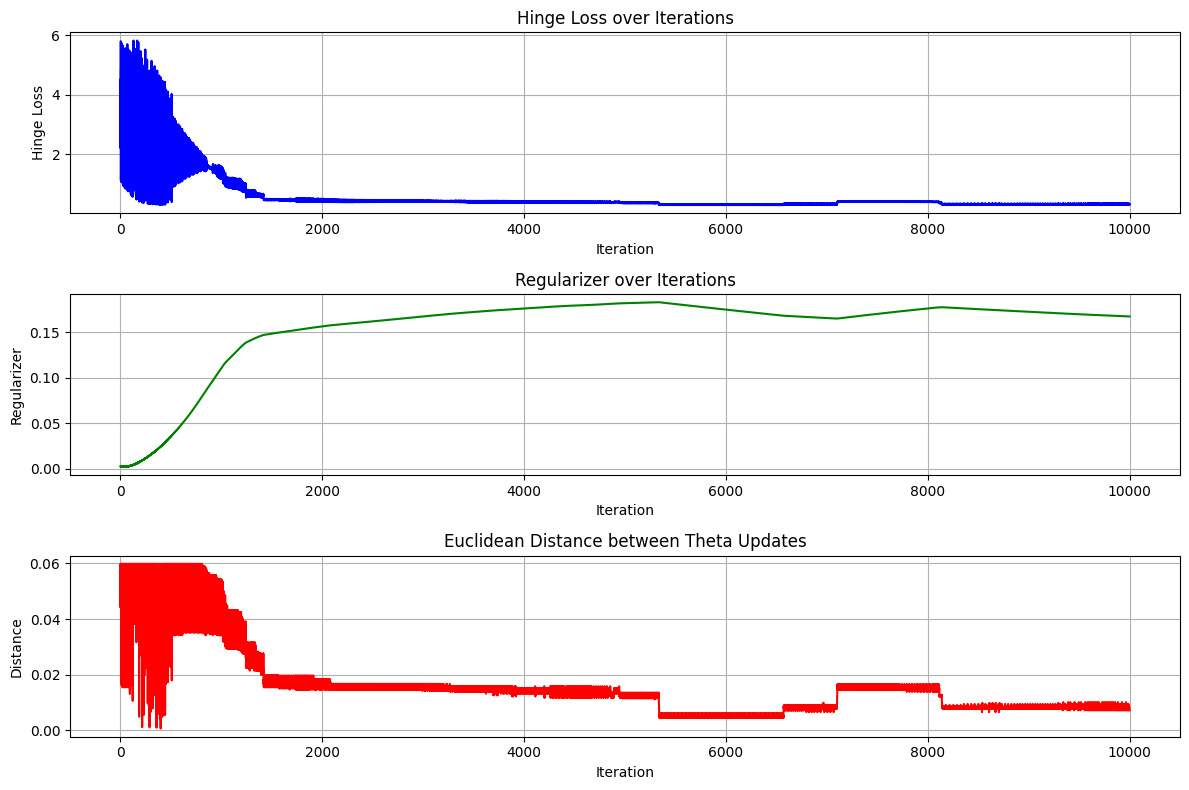

optimal_theta = array([[18.1503324 ],
       [-1.10389675],
       [ 1.93406472]])


In [3]:
optimal_theta = SvmHelper.regularised_kernel_erm_batch(dataset.train_inputs, dataset.train_labels, 'linear', 10000, epsilon=best_params['epsilon'], alpha=best_params['alpha_0'], lbda=best_params['lambda_value'], verbose=False, figure=True)
print(f'{optimal_theta = }')

In [10]:
predictions, raw_predictions, inputs, theta=SvmHelper.predict(dataset.test_inputs, optimal_theta)

accuracy = accuracy_score(dataset.test_labels, predictions)
print(accuracy)

0.9


### Visualisation

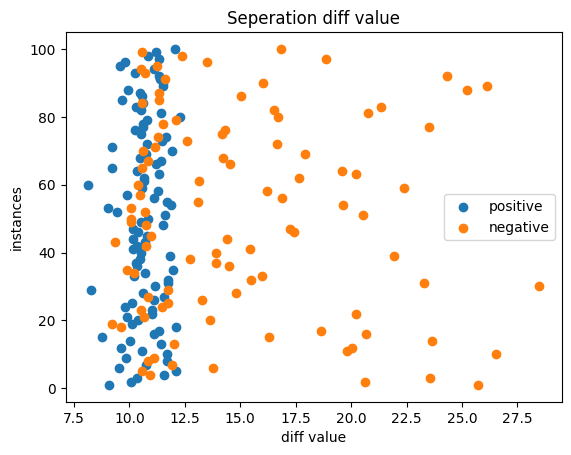

In [5]:
positive_inputs, positive_labels = dataset.filter_by_label(1)
negative_inputs, negative_labels = dataset.filter_by_label(-1)

positive_x = range(1, len(positive_inputs) + 1)
negative_x = range(1, len(negative_inputs) + 1)

plt.scatter(positive_inputs[:,1], range(1, 101), label="positive")
plt.scatter(negative_inputs[:,1], range(1, 101), label="negative")

plt.title(f'Seperation diff value')
plt.xlabel('diff value')
plt.ylabel('instances')
plt.legend()
plt.show()

**Derivation decision boundary:**

$$
z = \theta_1*x_1+\theta_2*x_2+\theta_0 \mid z = 0
$$
$$
0 = \theta_1*x_1+\theta_2*x_2+\theta_0 \mid Aim: x_2
$$
$$
-\theta_0 =  \theta_1*x_1+\theta_2*x_2 \mid -(\theta_1*x_1)
$$
$$
-\theta_0-(\theta_1*x_1) = \theta_2*x_2 \mid :\theta_2
$$
$$
\frac{-\theta_0-(\theta_1*x_1)}{\theta_2} = x_2 
$$

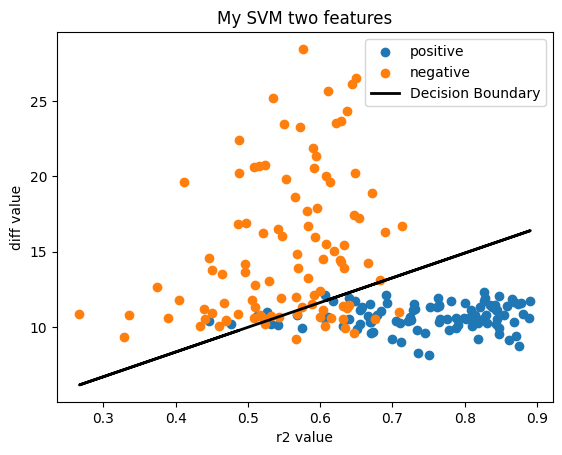

In [6]:
def calculate_y(optimal_theta, x1):
    x2=(-optimal_theta[-1] - (optimal_theta[0]*x1)) / optimal_theta[1]
    return x2

x2 = calculate_y(optimal_theta, dataset.inputs[:,0])

plt.scatter(positive_inputs[:,0], positive_inputs[:,1], label="positive")
plt.scatter(negative_inputs[:,0], negative_inputs[:,1], label="negative")
plt.plot(dataset.inputs[:,0], x2, color='black', linewidth=2, label='Decision Boundary')
plt.title(f'My SVM two features')
plt.xlabel('r2 value')
plt.ylabel('diff value')
plt.legend()
plt.show()

### sklearn SVM

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

if dataset.train_inputs.ndim == 1:
    dataset.train_inputs = dataset.train_inputs.reshape(-1, 1)
if dataset.test_inputs.ndim == 1:
    dataset.test_inputs = dataset.test_inputs.reshape(-1, 1)

if dataset.train_labels.ndim != 1:
    dataset.train_labels = dataset.train_labels.ravel()
if dataset.test_labels.ndim != 1:
    dataset.test_labels = dataset.test_labels.ravel()

svm_linear = SVC(kernel="linear")
svm_linear.fit(dataset.train_inputs, dataset.train_labels)

y_pred = svm_linear.predict(dataset.test_inputs)

accuracy = accuracy_score(dataset.test_labels, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(dataset.test_labels, y_pred))


Accuracy: 0.88
              precision    recall  f1-score   support

          -1       0.94      0.80      0.86        20
           1       0.83      0.95      0.88        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40



In [8]:
weights = svm_linear.coef_
intercept = svm_linear.intercept_

print("Weights (coefficients):", weights)
print("Intercept (bias):", intercept)

Weights (coefficients): [[ 4.76802364 -0.41760378]]
Intercept (bias): [1.8956753]


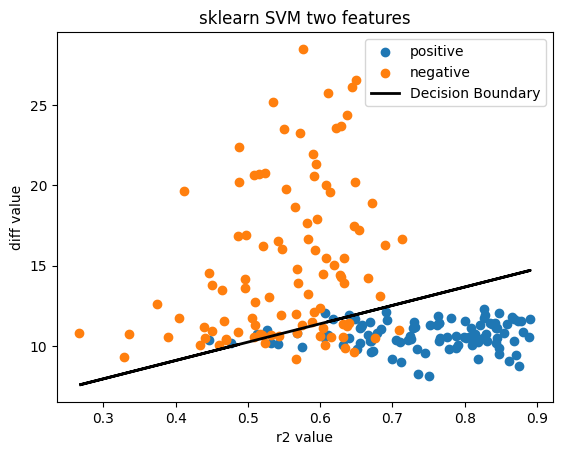

In [9]:
intercept = intercept.reshape(1,1)
merged_weights = np.hstack((weights,intercept)).reshape(3,1)

x2 = calculate_y(merged_weights, dataset.inputs[:,0])

plt.scatter(positive_inputs[:,0], positive_inputs[:,1], label="positive")
plt.scatter(negative_inputs[:,0], negative_inputs[:,1], label="negative")
plt.plot(dataset.inputs[:,0], x2, color='black', linewidth=2, label='Decision Boundary')
plt.title(f'sklearn SVM two features')
plt.xlabel('r2 value')
plt.ylabel('diff value')
plt.legend()
plt.show()
